In [ ]:
#0728 怎麼categorical 標準化、各種encoder應用
#找不到原作者的邏輯
#@title Imports
!wget "https://github.com/YI-CHENG-SHIH645/ML-in-Business_practice/raw/master/utils.py"

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from utils import display_side_by_side, DataLoader

np.random.seed(3)

--2023-08-04 13:39:06--  https://github.com/YI-CHENG-SHIH645/ML-in-Business_practice/raw/master/utils.py
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/YI-CHENG-SHIH645/ML_Intro/raw/master/utils.py [following]
--2023-08-04 13:39:06--  https://github.com/YI-CHENG-SHIH645/ML_Intro/raw/master/utils.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YI-CHENG-SHIH645/ML_Intro/master/utils.py [following]
--2023-08-04 13:39:07--  https://raw.githubusercontent.com/YI-CHENG-SHIH645/ML_Intro/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request se

## 資料前處理

In [ ]:
iowa_original_df = DataLoader.load_data('iowa_original')
#iowa_original_df.info()

In [ ]:
train_dtype = iowa_original_df.dtypes
train_dtype.value_counts()

object    48
int64     33
dtype: int64

In [ ]:
test_data = pd.read_csv(r"test.csv")
test_dtype = test_data.dtypes
test_dtype.value_counts()

object     43
int64      26
float64    11
dtype: int64

In [ ]:
train_y = pd.DataFrame(iowa_original_df["SalePrice"])
train =iowa_original_df.drop("SalePrice",axis = 1)

train.replace("NA", None, inplace=True)
train= pd.concat((train, test_data)).reset_index(drop=True)
train = train.drop("Id",axis =1)
#原本有Na統一變None
for col in ("PoolQC","MiscFeature","Alley","Fence","FireplaceQu"):
    train[col] = train[col].fillna("None")
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,6,2006,WD,Normal
4363,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,4,2006,WD,Abnorml
4364,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2006,WD,Abnorml
4365,85,RL,62.0,10441,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,Shed,700,7,2006,WD,Normal


In [ ]:
train.isna().sum().sort_values(ascending = False).head(30)

LotFrontage     713
GarageCond      236
GarageYrBlt     236
GarageFinish    236
GarageQual      236
GarageType      233
BsmtCond        125
BsmtExposure    124
BsmtQual        123
BsmtFinType2    120
BsmtFinType1    119
MasVnrType       40
MasVnrArea       38
MSZoning          7
Utilities         4
BsmtHalfBath      3
BsmtFullBath      3
Exterior1st       2
SaleType          2
KitchenQual       2
Functional        2
Exterior2nd       2
BsmtUnfSF         1
GarageCars        1
GarageArea        1
Electrical        1
BsmtFinSF2        1
BsmtFinSF1        1
TotalBsmtSF       1
TotRmsAbvGrd      0
dtype: int64

In [ ]:
#LotFrontage:與房子相連的街道距離，可能與同區域間的房子相似，所以拿Neighborhood同區的中位數當作替代值
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [ ]:
#GarageCond:車庫條件,GarageQual:車庫等級,GarageFinish:車庫內部裝潢,GarageType:車庫位置
for col in ("GarageCond","GarageQual","GarageFinish","GarageType"):
     train[col] = train[col].fillna("None")

In [ ]:
#GarageYrBlt:車庫建照年份,GarageArea:車庫面積,GarageCars:車庫可容納車子的數量(為數值，所以缺值直接補0)
for col in ("GarageYrBlt","GarageArea","GarageCars"):
     train[col] =  train[col].fillna(0)

In [ ]:
#BsmtCond : 地下室的狀況,BsmtExposure:地下室採光程度,BsmtQual:地下室高度,BsmtFinType1:地下室1的等級,BsmtFinType2:地下室2的等級
for col in ("BsmtCond","BsmtExposure","BsmtQual","BsmtFinType1","BsmtFinType2"):
     train[col] = train[col].fillna("None")
#BsmtFinSF1:地下室1的面積,BsmtFinSF2:地下室2的面積,BsmtHalfBath:地下室半浴室數量,BsmtFullBath:地下室全浴室數量,BsmtUnfSF:未完成的地下室面積,TotalBsmtSF:地下室總面積(為數值，所以缺值直接補0)
for col in ("BsmtFinSF1","BsmtFinSF2","BsmtHalfBath","BsmtFullBath","BsmtUnfSF","TotalBsmtSF",):
    train[col] = train[col].fillna(0)

In [ ]:
#MasVnrType:砌體材質
train["MasVnrType"] = train["MasVnrType"].fillna("None")
#MasVnrArea:砌體面積
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

In [ ]:
#MSZoning:銷售的住宅類型，正常應該要有值，所以拿最常出現的RL(低密度住宅區)來代替
train["MSZoning"] = train["MSZoning"].fillna(train["MSZoning"].mode()[0])

In [ ]:
#Utilities:水電等公共設施種類，雖然公共設施越多應該要月貴，但該特徵值除了1個NoSeWa以及2個nan外，其餘都是AllPub，而NoSeWa正好只在訓練集，對於我們預測的數據沒有幫助，所以可以直接刪除這個特徵值
train =  train.drop(["Utilities"],axis=1)

In [ ]:
#Functional:家電功能等級，Typ為典型的，也就是一般的，所以缺值的部分最常出現的Typ代替
train["Functional"] = train["Functional"].fillna("Typ")

In [ ]:
#Exterior1st,Exterior2nd:房屋外牆飾面，只有1個缺值，所以用最多的數值補
train["Exterior1st"] = train["Exterior1st"].fillna(train["Exterior1st"].mode()[0])
train["Exterior2nd"]= train["Exterior2nd"].fillna(train["Exterior2nd"].mode()[0])

#SaleType:銷售類型，缺值一樣只有一個，所以用最普遍的WD(常規的契約)來替補
train["SaleType"] = train["SaleType"].fillna(train["SaleType"].mode()[0])

#Electrical:電力系統，缺值只有一個，所有用最普遍的SBrkr(標準的電力系統)來替補
train["Electrical"] = train["Electrical"].fillna(train["Electrical"].mode()[0])


#KitchenQual:廚房等級，缺值只有一個，所以用最普遍的TA(典型(中等)的等級)來替補
train["KitchenQual"] = train["KitchenQual"].fillna(train["KitchenQual"].mode()[0])


In [ ]:
train.isnull().sum().sort_values(ascending = True)
#缺失值處理結束

MSSubClass       0
FireplaceQu      0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
                ..
MasVnrType       0
Exterior2nd      0
Exterior1st      0
BsmtQual         0
SaleCondition    0
Length: 78, dtype: int64

In [ ]:
'''
o_f = train[cate_feature]
#用label encoder處理非數值資料

from sklearn.preprocessing import OrdinalEncoder
'''
cate_feature =train.dtypes[train.dtypes == object].index
object_feature = train[cate_feature]

train_object = object_feature[:len(iowa_original_df)]
train_y = pd.DataFrame(iowa_original_df["SalePrice"])
train_y.index = iowa_original_df["Id"]
train_object["SalePrice"] = train_y
from sklearn.preprocessing import LabelEncoder
for i in cate_feature:
  object_feature[i] = LabelEncoder().fit_transform(object_feature[i])
  #pd.factorize(object_feature[i])[0]
object_feature

<ipython-input-388-94a393515b05>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_object["SalePrice"] = train_y
<ipython-input-388-94a393515b05>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  object_feature[i] = LabelEncoder().fit_transform(object_feature[i])
<ipython-input-388-94a393515b05>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,4,0,5,2,2,...,1,2,5,5,2,3,4,1,8,4
1,3,1,1,3,3,2,0,24,1,2,...,1,2,5,5,2,3,4,1,8,4
2,3,1,1,0,3,4,0,5,2,2,...,1,2,5,5,2,3,4,1,8,4
3,3,1,1,0,3,0,0,6,2,2,...,5,3,5,5,2,3,4,1,8,0
4,3,1,1,0,3,2,0,15,2,2,...,1,2,5,5,2,3,4,1,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362,4,1,1,3,3,4,0,10,2,2,...,6,1,3,3,2,3,4,1,8,4
4363,4,1,1,3,3,4,0,10,2,2,...,4,3,5,5,2,3,4,1,8,0
4364,3,1,1,3,3,4,0,11,2,2,...,5,3,5,5,2,3,4,1,8,0
4365,3,1,1,3,3,4,0,11,2,2,...,6,1,3,3,2,3,2,3,8,4


In [ ]:
#接下來就是處理數值類型的特徵值，但我們先前在分類特徵值時就可以發現，
#數值型特徵值中像「MSSubClass、OverallQual以及OverallCond」也都是屬於離散的分類特徵值，因此我們先將這兩類特徵值區分開來
classification_int_float = ["MSSubClass","OverallQual","OverallCond"]
int_float_feature = train[train.dtypes[train.dtypes != object].index]
all_int_float = int_float_feature.drop(classification_int_float,axis = 1)
train_int_float = all_int_float[:len(iowa_original_df)]
train_int_float["SalePrice"] = train_y
train_int_float

<ipython-input-389-af3e81733c6a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_int_float["SalePrice"] = train_y


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,65.0,8450,2003,2003,196.0,706.0,0.0,150.0,856.0,856,...,0,61,0,0,0,0,0,2,2008,NaN
1,80.0,9600,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,...,298,0,0,0,0,0,0,5,2007,12.247699
2,68.0,11250,2001,2002,162.0,486.0,0.0,434.0,920.0,920,...,0,42,0,0,0,0,0,9,2008,12.109016
3,60.0,9550,1915,1970,0.0,216.0,0.0,540.0,756.0,961,...,0,35,272,0,0,0,0,2,2006,12.317171
4,84.0,14260,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,...,192,84,0,0,0,0,0,12,2008,11.849405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2903,21.0,1936,1970,1970,0.0,0.0,0.0,546.0,546.0,546,...,0,0,0,0,0,0,0,6,2006,12.676079
2904,21.0,1894,1970,1970,0.0,252.0,0.0,294.0,546.0,546,...,0,24,0,0,0,0,0,4,2006,12.793584
2905,160.0,20000,1960,1996,0.0,1224.0,0.0,0.0,1224.0,1224,...,474,0,0,0,0,0,0,9,2006,11.308371
2906,62.0,10441,1992,1992,0.0,337.0,0.0,575.0,912.0,970,...,80,32,0,0,0,0,700,7,2006,12.278398


In [ ]:
#接著，我們發現許多特徵值的數值相當大，差距也很大，且每個特徵值的單位也不競相同，因此我們使用「log」來標準化特徵
import numpy as np
log_all_int_float = np.log1p(all_int_float)
log_all_int_float

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,4.189655,9.042040,7.602900,7.602900,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,...,6.308098,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.000000,1.098612,7.605392
1,4.394449,9.169623,7.589336,7.589336,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,...,6.133398,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.791759,7.604894
2,4.234107,9.328212,7.601902,7.602401,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,...,6.411818,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.000000,2.302585,7.605392
3,4.110874,9.164401,7.557995,7.586296,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,...,6.466145,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.000000,1.098612,7.604396
4,4.442651,9.565284,7.601402,7.601402,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,...,6.729824,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.000000,2.564949,7.605392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362,3.091042,7.568896,7.586296,7.586296,0.000000,0.000000,0.0,6.304449,6.304449,6.304449,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.945910,7.604396
4363,3.091042,7.546974,7.586296,7.586296,0.000000,5.533389,0.0,5.686975,6.304449,6.304449,...,5.659482,0.000000,3.218876,0.000000,0.0,0.0,0.0,0.000000,1.609438,7.604396
4364,5.081404,9.903538,7.581210,7.599401,0.000000,7.110696,0.0,0.000000,7.110696,7.110696,...,6.357842,6.163315,0.000000,0.000000,0.0,0.0,0.0,0.000000,2.302585,7.604396
4365,4.143135,9.253591,7.597396,7.597396,0.000000,5.823046,0.0,6.356108,6.816736,6.878326,...,0.000000,4.394449,3.496508,0.000000,0.0,0.0,0.0,6.552508,2.079442,7.604396


In [ ]:
classificantion_feature = int_float_feature[classification_int_float]
classificantion_feature_train = classificantion_feature[:len(iowa_original_df)]
classificantion_feature_train["SalePrice"] = train_y

for col in classificantion_feature_train.columns:
    data = classificantion_feature_train.groupby([col])[["SalePrice"]].agg(['mean','median','count'])
    sort_data = data.sort_values(data.columns[1],ascending = True)#根據中位數排序
    print(sort_data)


            SalePrice                 
                 mean     median count
MSSubClass                            
40          11.754502  11.711785     6
70          11.817515  11.794345   127
45          11.961389  11.849398    18
90          11.905149  11.870257   108
30          11.917208  11.891369   139
50          11.908339  11.901590   283
190         11.898166  11.941415    60
150         11.964007  11.964007     1
75          12.003333  11.970357    23
20          12.030197  11.994277  1070
80          12.064282  12.017939   118
160         12.114212  12.066816   128
60          12.109708  12.086732   570
120         12.106597  12.086732   181
85          12.045319  12.094588    47
180         12.242686  12.154785    17
             SalePrice                 
                  mean     median count
OverallQual                            
1            11.903867  11.759793     3
2            11.844949  11.877576    13
3            11.947865  11.904974    39
5            11.959

<ipython-input-391-4e7ea23a8503>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classificantion_feature_train["SalePrice"] = train_y


In [ ]:
MSSubClass_dict = {40:1,70:1,45:1,90:1,
                  30:2,50:2,190:2,150:2,75:2,
                  20:3,80:3,
                   160:4,60:4,
                  120:5,85:5,
                  180:6}
#-------------------------------------------------------
OverallCond_dict = {1:1,
                   3:2,9:2,
                   4:3,
                   2:4,7:4,6:4,8:4,
                  5:5}
#-------------------------------------------------------
OverallQual_dict = {1:1,2:2,3:3,4:5,
                   5:4,6:6,7:7,8:8,
                  9:9,10:10}
classificantion_feature["MSSubClass"] =classificantion_feature["MSSubClass"].map(MSSubClass_dict)
classificantion_feature["OverallCond"] = classificantion_feature["OverallCond"].map(OverallCond_dict)
classificantion_feature["OverallQual"] = classificantion_feature["OverallQual"].map(OverallQual_dict)

<ipython-input-392-9e1784364bbe>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classificantion_feature["MSSubClass"] =classificantion_feature["MSSubClass"].map(MSSubClass_dict)
<ipython-input-392-9e1784364bbe>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classificantion_feature["OverallCond"] = classificantion_feature["OverallCond"].map(OverallCond_dict)
<ipython-input-392-9e1784364bbe>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [ ]:
all_feature = pd.concat( [object_feature, log_all_int_float,classificantion_feature], axis=1 )
all_feature

,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass,OverallQual,OverallCond
0,3,1,1,3,3,4,0,5,2,2,...,0.000000,0.0,0.0,0.0,0.000000,1.098612,7.605392,4,7,5
1,3,1,1,3,3,2,0,24,1,2,...,0.000000,0.0,0.0,0.0,0.000000,1.791759,7.604894,3,6,4
2,3,1,1,0,3,4,0,5,2,2,...,0.000000,0.0,0.0,0.0,0.000000,2.302585,7.605392,4,7,5
3,3,1,1,0,3,0,0,6,2,2,...,5.609472,0.0,0.0,0.0,0.000000,1.098612,7.604396,1,7,5
4,3,1,1,0,3,2,0,15,2,2,...,0.000000,0.0,0.0,0.0,0.000000,2.564949,7.605392,4,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362,4,1,1,3,3,4,0,10,2,2,...,0.000000,0.0,0.0,0.0,0.000000,1.945910,7.604396,4,5,4
4363,4,1,1,3,3,4,0,10,2,2,...,0.000000,0.0,0.0,0.0,0.000000,1.609438,7.604396,4,5,5
4364,3,1,1,3,3,4,0,11,2,2,...,0.000000,0.0,0.0,0.0,0.000000,2.302585,7.604396,3,4,4
4365,3,1,1,3,3,4,0,11,2,2,...,0.000000,0.0,0.0,0.0,6.552508,2.079442,7.604396,5,4,5


In [ ]:
#接回原狀
train_x = all_feature[:len(iowa_original_df)]
test_x = all_feature[len(iowa_original_df):]
train_x.shape,test_x.shape

((2908, 78), (1459, 78))

# Lasso結果

In [ ]:

from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(train_x,train_y)#salesprice以外的參數，saleprice
train_score = lasso.score(train_x,train_y)
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse
score = rmse_cv(lasso,train_x ,train_y.values.ravel())#ravel降為一維
print("{} mean score(Standard Deviation score) : {:.4f} ({:.4f})".format("Lasso",score.mean(),score.std()))
#可以調整不同的參數組合找到score最小的作為參數篩選
#label encoder mean score最小(假設沒有順序)
#ordinal encoder ，根據勤業的資料，僅有風險等級有明顯順序
#Binary Encoder 只會跑出必要的0和1位數，onehot encoder則是會依據參數數量跑出個數

Lasso mean score(Standard Deviation score) : 0.4025 (0.0072)


# 隨機森林

In [ ]:
#梯度提升回歸樹(GradientBoostingRegressor)的RMSE最低，平均得到了0.1223，標準差為0.0116，所以我們就挑選梯度提升回歸樹作為我們的特徵篩選模型

In [ ]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
#定義一下我們交叉驗證的函式，我們設定成5次，得分定義成RMSE(neg_mean_squared_error)
test_y = pd.read_csv(r"sample_submission.csv",index_col = "Id")
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

train_y_v = train_y.values.ravel()#降成一維以做隨機森林
test_y_v= test_y.values.ravel()
train_x.shape,train_y_v.shape,test_x.shape,test_y_v.shape
#隨機迴歸森林
rfr = RandomForestRegressor(n_jobs=-1, n_estimators=100)
rfr.fit(train_x,train_y_v)

#極端迴歸森林
etr = ExtraTreesRegressor()
etr.fit(train_x,train_y_v)

#梯度提升迴歸樹
gbr = GradientBoostingRegressor()
gbr.fit(train_x,train_y_v)

name = ["RandomForestRegressor","ExtraTreesRegressor","GradientBoostingRegressor"]
model = [rfr,etr,gbr]
for n,m in zip(name,model):
    predict_y = m.predict(test_x)
    predict = pd.DataFrame(predict_y,index = test_y.index,columns = ["SalePrice"])
    score = rmse_cv(m,train_x ,train_y.values.ravel())
    print("{} mean score : {:.4f} ({:.4f})".format(n,score.mean(),score.std()))


RandomForestRegressor mean score : 0.1341 (0.0113)
ExtraTreesRegressor mean score : 0.1293 (0.0085)
GradientBoostingRegressor mean score : 0.1223 (0.0116)


<Axes: >

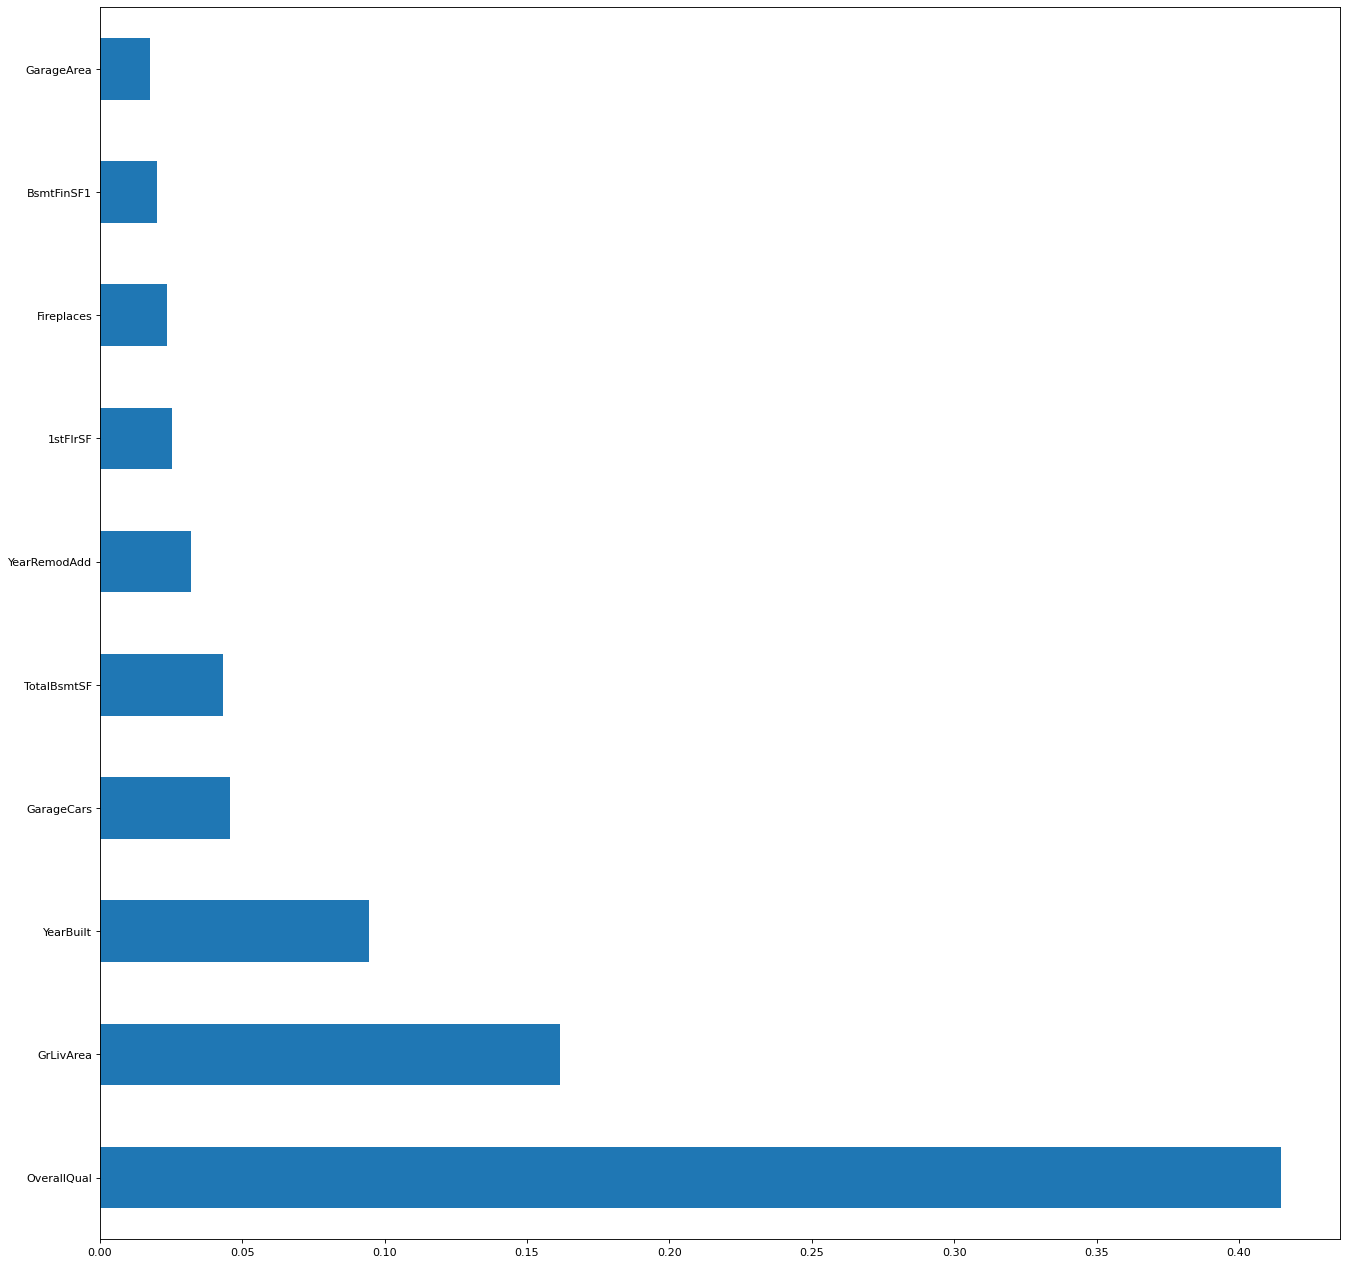

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')

feat_importances = pd.Series(gbr.feature_importances_, index= train_x.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
#用此模型我們挑選與預測目標最相關的10個特徵值作為我們的最終特徵值
final_feature = train_x [feat_importances.nlargest(10).index]
final_feature

,OverallQual,GrLivArea,YearBuilt,GarageCars,TotalBsmtSF,YearRemodAdd,1stFlrSF,Fireplaces,BsmtFinSF1,GarageArea
0,7,7.444833,7.602900,1.098612,6.753438,7.602900,6.753438,0.000000,6.561031,6.308098
1,6,7.141245,7.589336,1.098612,7.141245,7.589336,7.141245,0.693147,6.886532,6.133398
2,7,7.488294,7.601902,1.098612,6.825460,7.602401,6.825460,0.693147,6.188264,6.411818
3,7,7.448916,7.557995,1.386294,6.629363,7.586296,6.869014,0.693147,5.379897,6.466145
4,8,7.695758,7.601402,1.386294,7.044033,7.601402,7.044033,0.693147,6.486161,6.729824
...,...,...,...,...,...,...,...,...,...,...
2903,5,6.996681,7.586296,0.000000,6.304449,7.586296,6.304449,0.000000,0.000000,0.000000
2904,5,6.996681,7.586296,0.693147,6.304449,7.586296,6.304449,0.000000,5.533389,5.659482
2905,4,7.110696,7.581210,1.098612,7.110696,7.599401,7.110696,0.693147,7.110696,6.357842
2906,4,6.878326,7.597396,0.000000,6.816736,7.597396,6.878326,0.000000,5.823046,0.000000


<ipython-input-374-8791d5b2baf8>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(iowa_original_df['SalePrice'] , fit=norm);



 mu = 180272.21 and sigma = 78125.65



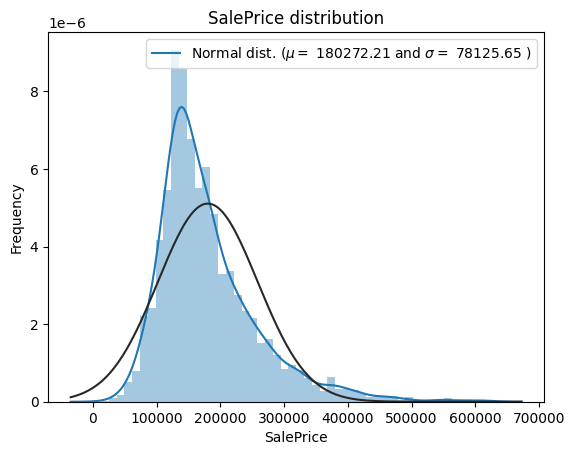

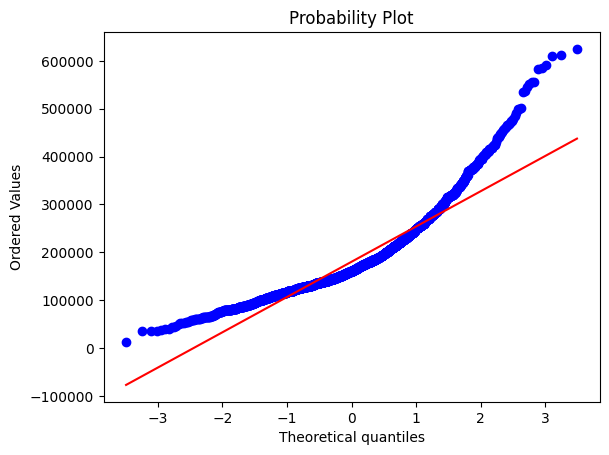

In [ ]:
#觀察房價的分布
from scipy.stats import norm
from scipy import stats
import seaborn as sns
sns.distplot(iowa_original_df['SalePrice'] , fit=norm);
#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(iowa_original_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(iowa_original_df['SalePrice'], plot=plt)
plt.show()

<ipython-input-375-790b3332bc48>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(iowa_original_df["SalePrice"] , fit=norm);



 mu = 12.02 and sigma = 0.40



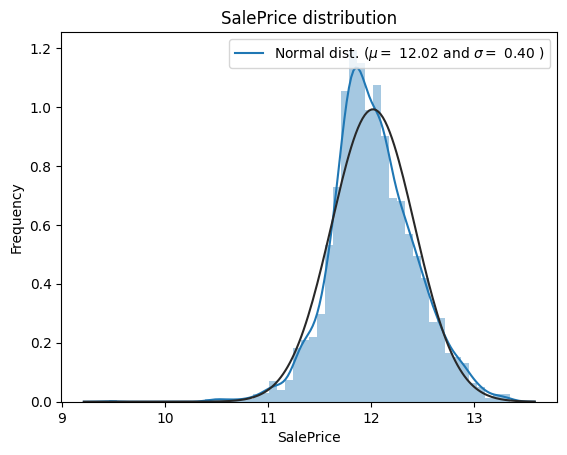

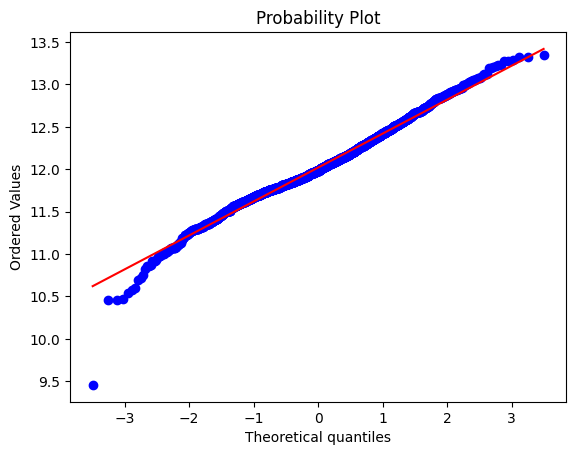

In [ ]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
iowa_original_df["SalePrice"] = np.log1p(iowa_original_df["SalePrice"])
#Check the new distribution
sns.distplot(iowa_original_df["SalePrice"] , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(iowa_original_df["SalePrice"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(iowa_original_df["SalePrice"], plot=plt)
plt.show()
#我們可以從圖中發現，我們的預測目標房價出現了厚尾的現象，代表出現極端離群值的機率較高，這將會影響我們預測時的準確性，因此我們對預測目標進行「log」的轉換，讓數值範圍縮小，以減少厚尾的現象